# Note:
Specifically a notebook for analyzing results from .csv and making pretty figures.

## Loading Datasets:
Intially raw from Datasets

In [58]:
import pandas as pd
import numpy as np
import os
import re

# Load Dataset and Synce with image paths
def sync_data(dataset_name):
    
    path = "Datasets/" + dataset_name + "/"
    df = pd.read_csv(path+"robot_state.csv")
    
    df["ID"] = df["command"].str.extract(r'(\d+)').astype(int)
    
    # Add Images to DF
    image_paths = [f for f in os.listdir(path)
                   if f.startswith("capture") and f.endswith(".png")]
    
    id_to_path = {}
    for fname in image_paths:
        m = re.search(r'capture(\d+)_', fname)
        if m:
            img_id = int(m.group(1))
            id_to_path[img_id] = os.path.join(path, fname)

    df["image_path"] = df["ID"].map(id_to_path)
    
    # Make DF cleaner
    df = df.drop(columns=["timestamp", "command"])
    df["ID"] = dataset_name + "-" + df["ID"].astype(str)
    df = df[["image_path", "ID"] + [c for c in df.columns if c not in ["image_path", "ID"]]]
    
    
    return df

In [59]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Plot random samples of images
def sample_images(df, n=5, keyframes = False):

    sample = df.sample(n)
    plt.figure(figsize=(3*n, 3))
    
    coord_pairs = []
    
    
    if keyframes:
        for col in df.columns:
            if col.startswith("2D_") and col.endswith("_x"):
                y_col = col[:-2] + "_y" 
                if y_col in df.columns:
                    coord_pairs.append((col, y_col))
    # Plot Image
    for idx, (_, row) in enumerate(sample.iterrows(), start=1):
        img_path = row["image_path"]
        img = Image.open(img_path)

        plt.subplot(1, n, idx)
        plt.imshow(img)
        plt.axis("off")
        plt.title(str(row.get("ID", "")))
        
        # Plot 2D keyframes from Dataframe
        if keyframes:
            for x_col, y_col in coord_pairs:
                x = row[x_col]
                y = row[y_col]
                if not (pd.isna(x) or pd.isna(y)):
                    # Y needs to be flipped
                    plt.scatter([x], [y], s=10, c="green")

    plt.tight_layout()
    plt.show()

In [60]:
# Training Datasets
df1 = sync_data("Train5000v2")
df2 = sync_data("Train1000v2-Room")
df3 = sync_data("Train1000v2-Warehouse")
df4 = sync_data("Train1000v2-Hospital")

train_df = pd.concat([df1, df2, df3, df4], axis=0)

# Test Datasets
test_df = sync_data("Test2000v2")

test_df.sample(5)

image_path               ID  \
1600  Datasets/Test2000v2/capture1601_20251202_20025...  Test2000v2-1601   
1568  Datasets/Test2000v2/capture1569_20251202_20000...  Test2000v2-1569   
326   Datasets/Test2000v2/capture327_20251202_181030...   Test2000v2-327   
1811  Datasets/Test2000v2/capture1812_20251202_20211...  Test2000v2-1812   
884   Datasets/Test2000v2/capture885_20251202_190003...   Test2000v2-885   

       J0_target   J1_target   J2_target   J3_target   J4_target   J5_target  \
1600  -91.902680  -69.235274  -13.219345  154.281531  142.499056 -170.468365   
1568   -3.159153  -58.244275 -104.778678    5.771892  145.842998  -88.191424   
326   -37.573008 -103.013488  -81.707735   62.934874  142.959827  -58.816436   
1811  125.856734 -113.105078   96.323733  -26.345591   56.203072  -94.825040   
884  -164.794772 -137.958242   93.987266   43.391448 -156.698444   25.803457   

       J0_actual   J1_actual  ...  2D_J2_Elbow_dist  2D_J3_Wrist_x  \
1600  -91.905161  -69.233851  ...          5.946266          463.0   
1568   -3.161010  -58.245907  ...          4.739853          617.0   
326   -37.572563 -103.016786  ...          7.629805          692.0   
1811  125.858311 -113.102687  ...          4.534703          694.0   
884  -164.793422 -137.957035  ...          4.876318          682.0   

      2D_J3_Wrist_y  2D_J3_Wrist_dist  2D_J4_Wrist_x  2D_J4_Wrist_y  \
1600          452.0          5.871625          478.0          452.0   
1568          534.0          4.672477          638.0          525.0   
326           408.0          8.122336          704.0          411.0   
1811          341.0          4.368780          698.0          324.0   
884            85.0          4.404227          700.0           97.0   

      2D_J4_Wrist_dist  2D_J5_Wrist_x  2D_J5_Wrist_y  2D_J5_Wrist_dist  
1600          5.808242          488.0          458.0          5.899838  
1568          4.695411          644.0          527.0          4.583854  
326           8.086188          700.0          410.0          7.976438  
1811          4.453653          712.0          340.0          4.508389  
884           4.337315          696.0          123.0          4.397864  

[5 rows x 68 columns]

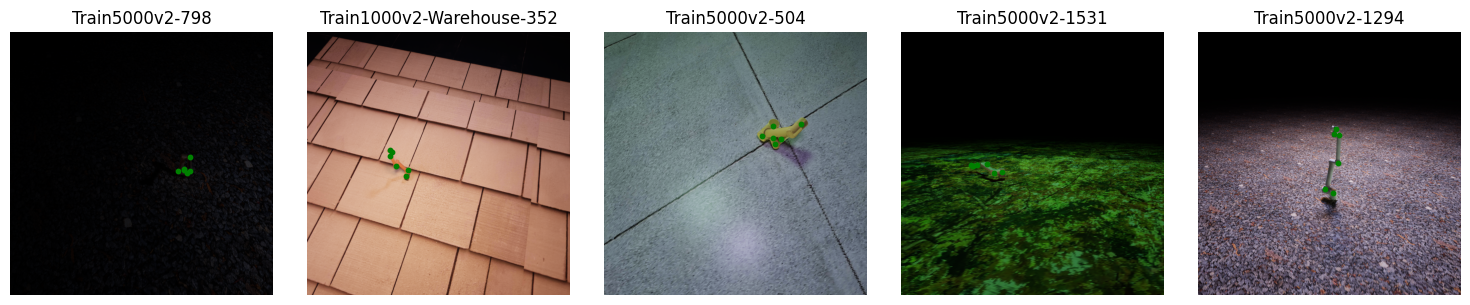

In [61]:
# Training Images
sample_images(train_df,n = 5, keyframes=True)

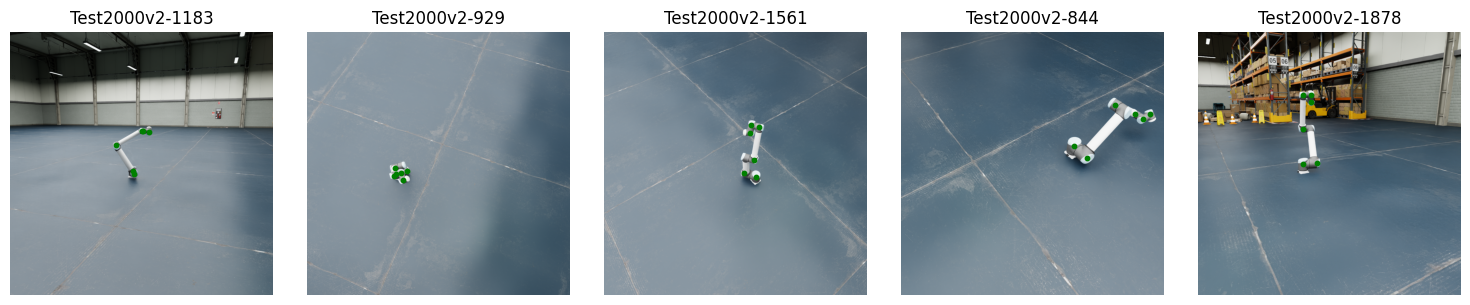

In [62]:
# Test Images
sample_images(test_df,n = 5, keyframes=True)

## Load Results
From csv file

In [63]:
# Load Dataset and Synce with image paths
path = "robot_pose_estimation/results/data/predictions.csv"

#Show Columns
results_df = pd.read_csv(path)
results_df['img_path'] = results_df['img_path'].str.replace('../../', '')
results_df = results_df.merge(
    test_df[["image_path", "2D_J0_Base_dist", "2D_J1_Shoulder_dist","2D_J2_Elbow_dist","2D_J3_Wrist_dist","2D_J4_Wrist_dist", "2D_J5_Wrist_dist"]],
    left_on="img_path",
    right_on="image_path",how="left")

#list(results_df.columns)

## Display Bounding Box

In [64]:
# Compute IoU of sample
def compute_iou(row):
    # Ground Truth box
    x1_gt = row["gt_bbox_xmin"]
    y1_gt = row["gt_bbox_ymin"]
    x2_gt = row["gt_bbox_xmax"]
    y2_gt = row["gt_bbox_ymax"]

    # Predicted box
    x1_p = row["pred_bbox_xmin"]
    y1_p = row["pred_bbox_ymin"]
    x2_p = row["pred_bbox_xmax"]
    y2_p = row["pred_bbox_ymax"]

    # Intersection
    xi1 = max(x1_gt, x1_p)
    yi1 = max(y1_gt, y1_p)
    xi2 = min(x2_gt, x2_p)
    yi2 = min(y2_gt, y2_p)
    inter_w = max(0, xi2 - xi1)
    inter_h = max(0, yi2 - yi1)
    intersection = inter_w * inter_h

    # Union area
    area_gt = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    area_pred = (x2_p - x1_p) * (y2_p - y1_p)
    union = area_gt + area_pred - intersection
    if union <= 0:
        return 0.0

    return intersection / union

In [65]:
def compute_mean_iou(df):
    df["IoU"] = df.apply(compute_iou, axis=1)

    mean_iou = df["IoU"].mean()
    std_iou  = df["IoU"].std()

    return mean_iou, std_iou, df["IoU"]

mean, std, df_iou = compute_mean_iou(results_df)
pct = (df_iou > 0.75).mean() * 100

print(f"Over dataset. IoU mean: {mean:.4f}, std: {std:.4f}")
print(f"{pct:.2f}% of samples")


Over dataset. IoU mean: 0.8639, std: 0.0795
93.00% of samples


In [66]:
df_iou.head()

0    0.748941
1    0.935130
2    0.845911
3    0.919704
4    0.923609
Name: IoU, dtype: float64

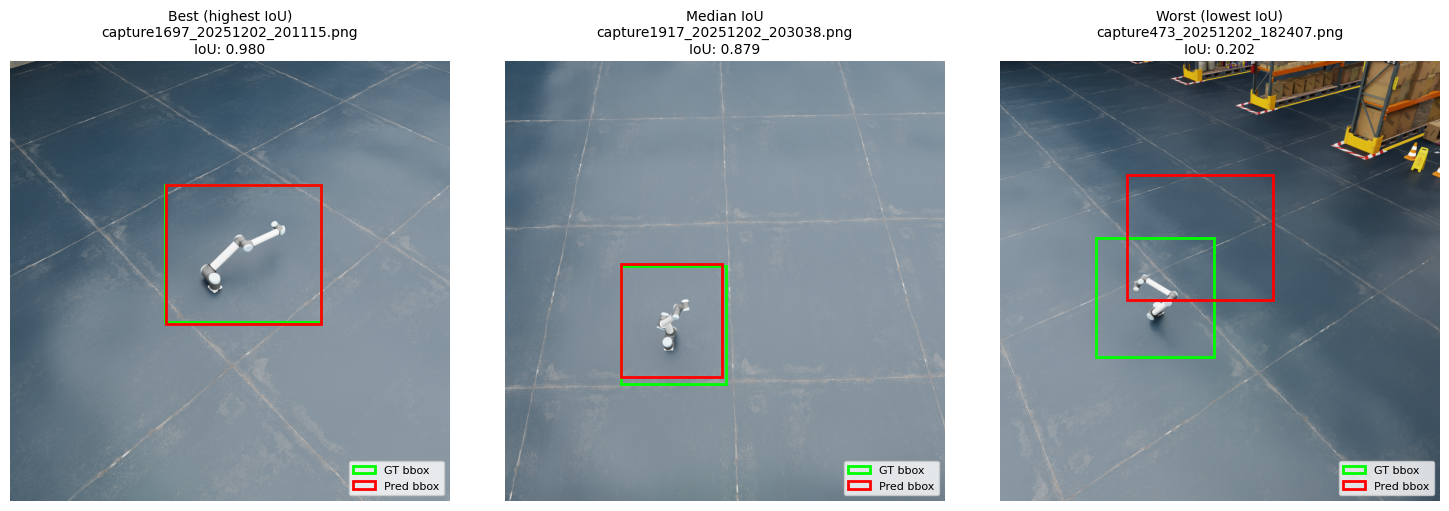

In [ ]:
from matplotlib import patches

joints = ["Base", "Shoulder", "Elbow", "Wrist3", "Wrist4", "Wrist5"]

def plot_bboxes_best_worst_iou(df):
    # Ensure IoU column exists (compute if missing)
    if "IoU" not in df.columns:
        df["IoU"] = df.apply(compute_iou, axis=1)

    ious = df["IoU"]

    # Best = highest IoU, Worst = lowest IoU, Median = closest to median IoU
    best_idx = ious.idxmax()
    worst_idx = ious.idxmin()
    median_val = ious.median()
    median_idx = (ious - median_val).abs().idxmin()

    ordered_indices = [best_idx, median_idx, worst_idx]
    labels = ["Best (highest IoU)", "Median IoU", "Worst (lowest IoU)"]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, idx, label in zip(axes, ordered_indices, labels):
        row = df.loc[idx]

        # Load image
        img = Image.open(row["img_path"])
        ax.imshow(img)
        ax.axis("off")

        # Ground truth bbox
        gt_xmin = row["gt_bbox_xmin"]
        gt_ymin = row["gt_bbox_ymin"]
        gt_xmax = row["gt_bbox_xmax"]
        gt_ymax = row["gt_bbox_ymax"]
        gt_w = gt_xmax - gt_xmin
        gt_h = gt_ymax - gt_ymin

        gt_rect = patches.Rectangle(
            (gt_xmin, gt_ymin), gt_w, gt_h,
            linewidth=2, edgecolor="lime", facecolor="none", label="GT bbox"
        )
        ax.add_patch(gt_rect)

        # Predicted bbox
        pred_xmin = row["pred_bbox_xmin"]
        pred_ymin = row["pred_bbox_ymin"]
        pred_xmax = row["pred_bbox_xmax"]
        pred_ymax = row["pred_bbox_ymax"]
        pred_w = pred_xmax - pred_xmin
        pred_h = pred_ymax - pred_ymin

        pred_rect = patches.Rectangle(
            (pred_xmin, pred_ymin), pred_w, pred_h,
            linewidth=2, edgecolor="red", facecolor="none", label="Pred bbox"
        )
        ax.add_patch(pred_rect)

        fname = row["img_path"].split("/")[-1]
        frame_iou = ious.loc[idx]

        ax.set_title(
            f"{label}\n{fname}\nIoU: {frame_iou:.3f}",
            fontsize=10
        )

        ax.legend(loc="lower right", fontsize=8)

    plt.tight_layout()
    plt.show()


plot_bboxes_best_worst_iou(results_df)


### Calculate 2D Error Distance by Pixels

In [ ]:
# Calculate Error Distance of Pixels
joints = ["Base", "Shoulder", "Elbow", "Wrist3", "Wrist4", "Wrist5"]
errors = {}

for joint in joints:
    x_gt = results_df[f"gt_{joint}_x"]
    y_gt = results_df[f"gt_{joint}_y"]
    x_pred = results_df[f"pred_{joint}_x"]
    y_pred = results_df[f"pred_{joint}_y"]
    error_dist = np.sqrt((x_pred - x_gt)**2 + (y_pred - y_gt)**2)
    errors[joint] = error_dist
combined = pd.concat([errors[j] for j in joints])

mean_val = combined.mean()
std_val = combined.std()

print("Overall mean:", mean_val)
print("Overall std:", std_val)

Overall mean: 14.41305697267869
Overall std: 15.116980133968411


In [ ]:
joints = ["Base", "Shoulder", "Elbow", "Wrist3", "Wrist4", "Wrist5"]
errors_c = {}
total = []

for joint in joints:
    error_dist = results_df[f"error_2d_{joint}_px"]
    total.append(error_dist)
    errors_c[joint] = error_dist
    combined = pd.concat([results_df[f"error_2d_{j}_px"] for j in joints])

mean_val = combined.mean()
std_val = combined.std()

print("Mean:", mean_val)
print("STD:", std_val)


Mean: 14.413056972166666
STD: 15.116980141683925


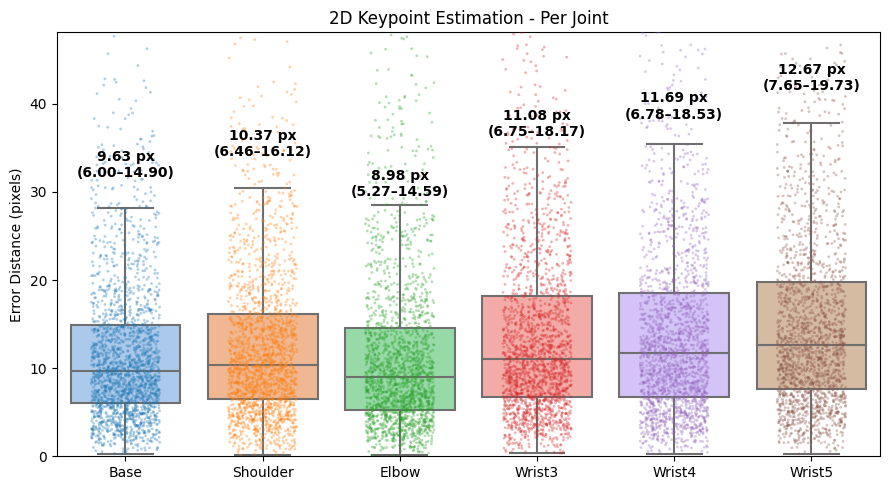

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))

error_df = pd.DataFrame(errors)
sns.boxplot(data=error_df,showfliers=False,palette = "pastel")
sns.stripplot(data=error_df,jitter=0.25,size=2,alpha=0.35)

# Plot median +/- IQR
medians = error_df.median()
q1, q3 = error_df.quantile(0.25), error_df.quantile(0.75)
x_positions = np.arange(len(error_df.columns))

for i, col in enumerate(error_df.columns):
    median = medians[col]
    q1_val, q3_val = q1[col], q3[col]
    
    plt.text(i, median * 3.25,
        f"{median:.2f} px\n({q1_val:.2f}–{q3_val:.2f})",
        ha='center', va='bottom',fontsize=10, fontweight='bold')

# Clip outliers
upper = error_df.quantile(0.95)
clipped = clipped = error_df.clip(upper=upper, axis=1)
plt.ylim(0, clipped.to_numpy().max() * 1.15)

plt.ylabel("Error Distance (pixels)")
plt.title("2D Keypoint Estimation - Per Joint")
plt.xticks(rotation=0)
plt.tight_layout()


plt.show()

## Calculate 2D Error in cm

In [71]:
# Camera Interinsics:
fx = 935.307424
fy = 1281.77511
cx = 540
cy = 540

# Recalculate error including camera distance.

joints = ["Base", "Shoulder", "Elbow", "Wrist3", "Wrist4", "Wrist5"]
cols = ["2D_J0_Base_dist", "2D_J1_Shoulder_dist","2D_J2_Elbow_dist","2D_J3_Wrist_dist","2D_J4_Wrist_dist", "2D_J5_Wrist_dist"]
body_lengths = [.220941, 0.635684, 0.5723, .1149, .1157]

errors = {}

for joint, col in zip(joints, cols):
    x_gt = results_df[f"gt_{joint}_x"]
    y_gt = results_df[f"gt_{joint}_y"]
    x_pred = results_df[f"pred_{joint}_x"]
    y_pred = results_df[f"pred_{joint}_y"]
    z = results_df[col]
    
    error_dist = z* np.sqrt(((x_pred - x_gt)/fx)**2 + ((y_pred - y_gt)/fy)**2) * 100
    errors[joint] = error_dist
    print(f'{joint} ADD: {sum(error_dist/2000)}')
combined = pd.concat([errors[j] for j in joints])

mean_val = combined.mean()
med_val = combined.median()
std_val = combined.std()

print("Mean:", mean_val)
print("STD:", std_val)
print("Median:", med_val)
    
# Calc ADD
all_errs = []
for joint in errors:
    all_errs.extend(errors[joint])  # flatten

add_total = np.mean(all_errs)
print("System ADD:", add_total)

Base ADD: 5.811695496772148
Shoulder ADD: 6.1395623621189985
Elbow ADD: 5.29035696446672
Wrist3 ADD: 6.5099665021933575
Wrist4 ADD: 6.550214104046149
Wrist5 ADD: 7.072802011292971
Mean: 6.229099573481716
STD: 7.369550344211079
Median: 4.550381369111966
System ADD: 6.229099573481716


AUC (raw):       24.0478
AUC (normalized): 0.8016


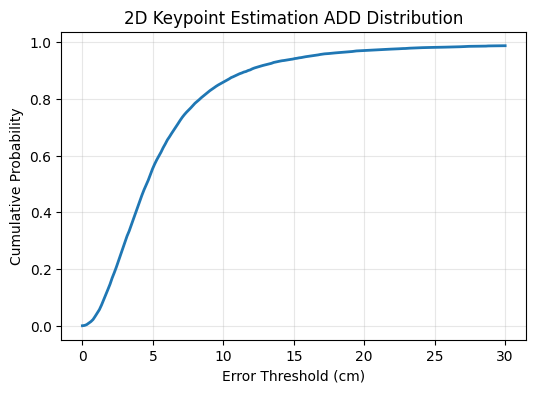

In [72]:


def compute_add_auc(errors, max_threshold=30, num_points=200):

    errors = np.array(errors)

    thresholds = np.linspace(0, max_threshold, num_points)
    acc = [(errors <= t).mean() for t in thresholds]

    auc_raw = np.trapz(acc, thresholds) 
    auc_norm = auc_raw / max_threshold

    return auc_raw, auc_norm, thresholds, acc

auc_raw, auc_norm, thresholds, acc = compute_add_auc(combined)

print(f"AUC (raw):       {auc_raw:.4f}")
print(f"AUC (normalized): {auc_norm:.4f}")

plt.figure(figsize=(6,4))
plt.plot(thresholds, acc, linewidth=2)
plt.xlabel("Error Threshold (cm)")
plt.ylabel("Cumulative Probability")
plt.title("2D Keypoint Estimation ADD Distribution")
plt.grid(alpha=0.3)
plt.show()

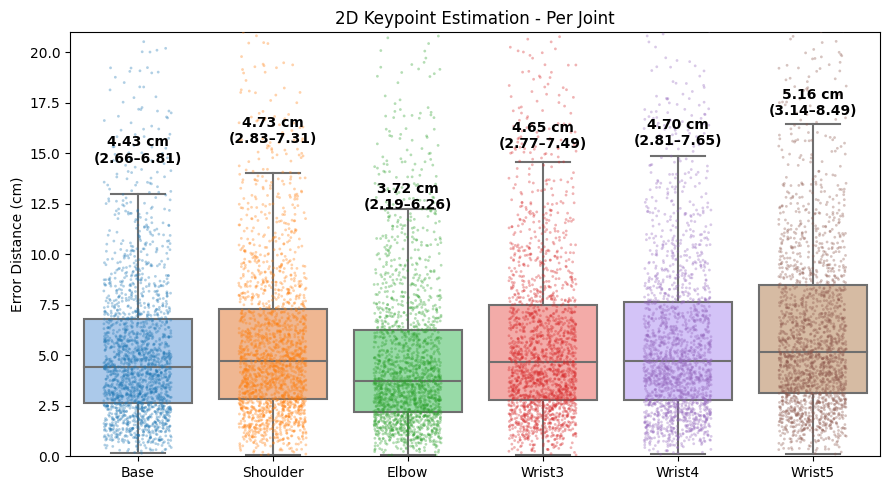

In [73]:
plt.figure(figsize=(9, 5))

error_df = pd.DataFrame(errors)
sns.boxplot(data=error_df,showfliers=False,palette = "pastel")
sns.stripplot(data=error_df,jitter=0.25,size=2,alpha=0.35)

# Plot median +/- IQR
medians = error_df.median()
q1, q3 = error_df.quantile(0.25), error_df.quantile(0.75)
x_positions = np.arange(len(error_df.columns))

for i, col in enumerate(error_df.columns):
    median = medians[col]
    q1_val, q3_val = q1[col], q3[col]
    
    plt.text(i, median * 3.25,
        f"{median:.2f} cm\n({q1_val:.2f}–{q3_val:.2f})",
        ha='center', va='bottom',fontsize=10, fontweight='bold')

# Clip outliers
upper = error_df.quantile(0.95)
clipped = clipped = error_df.clip(upper=upper, axis=1)
plt.ylim(0, clipped.to_numpy().max() * 1.15)

plt.ylabel("Error Distance (cm)")
plt.title("2D Keypoint Estimation - Per Joint")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'ECDF of Keypoint Prediction Error')

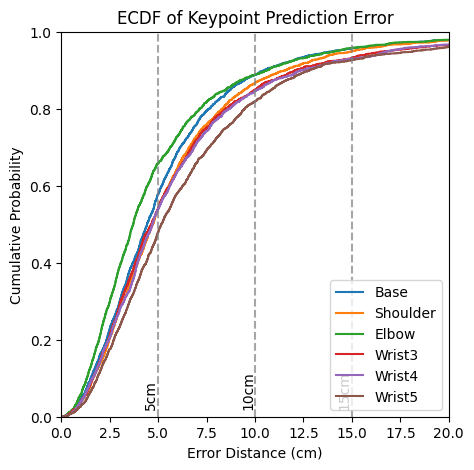

In [74]:
plt.figure(figsize=(5, 5))
for joint in joints:
    sns.ecdfplot(error_df[joint], label=joint)
    
thresholds = [5, 10, 15]
for t in thresholds:
    plt.axvline(t, linestyle="--", color="grey", alpha=0.7)
    plt.text(t, 0.02, f"{t}cm", rotation=90, va="bottom", ha="right")

plt.legend()
plt.xlim(0,20)
plt.xlabel("Error Distance (cm)")
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Keypoint Prediction Error")

## Keypoint Sample Images

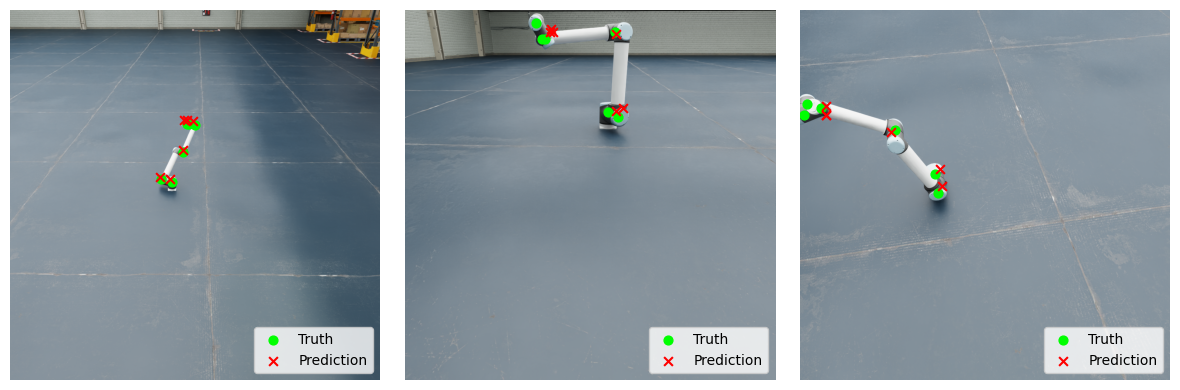

In [ ]:
import random
from PIL import Image

joints = ["Base", "Shoulder", "Elbow", "Wrist3", "Wrist4", "Wrist5"]

# Randomly sample different test images. With Keypoints
def sample_images(df, n = 3, gt = True, pred = True):
    df['img_path'] = df['img_path'].str.replace('../../', '')
    samples = results_df.sample(n)

    plt.figure(figsize=(12, 4))

    for i, (_, row) in enumerate(samples.iterrows()):
    # Load image
        img = Image.open(row["img_path"])

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")

        # Ground Truth
        if gt:
            x_gt, y_gt = [], []
            for joint in joints:
                x_gt.append(row[f"gt_{joint}_x"])
                y_gt.append(row[f"gt_{joint}_y"])
            plt.scatter(x_gt, y_gt, c="lime", s=40, marker="o", label="Truth")

        # Predictions
        if pred:
            x_pred, y_pred = [], []
            for joint in joints:
                x_pred.append(row[f"pred_{joint}_x"])
                y_pred.append(row[f"pred_{joint}_y"])
            plt.scatter(x_pred, y_pred, c="red", s=40, marker="x", label="Prediction")

        #plt.title(row["img_path"].split("/")[-1])
        plt.legend(loc="lower right")
            
    
    plt.tight_layout()
    plt.show()
sample_images(results_df)

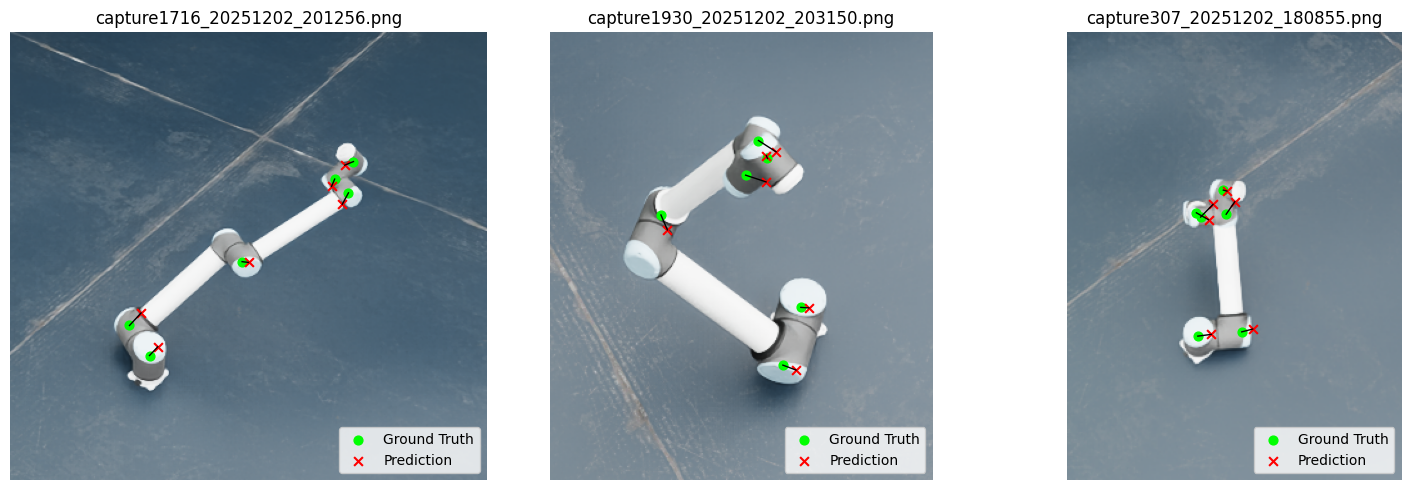

In [76]:
# With Cropped images 
joints = ["Base", "Shoulder", "Elbow", "Wrist3", "Wrist4", "Wrist5"]

def sample_images_cropped(df, n=3, show_gt=True, show_pred=True):
    samples = df.sample(n)
    plt.figure(figsize=(5 * n, 5))

    for i, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row["img_path"])

        # Get Bounding Box
        xmin = int(row["pred_bbox_xmin"])
        ymin = int(row["pred_bbox_ymin"])
        xmax = int(row["pred_bbox_xmax"])
        ymax = int(row["pred_bbox_ymax"])

        # Crop Image
        w, h = img.size
        xmin = max(0, min(xmin, w - 1))
        xmax = max(0, min(xmax, w))
        ymin = max(0, min(ymin, h - 1))
        ymax = max(0, min(ymax, h))
        cropped = img.crop((xmin, ymin, xmax, ymax))

        plt.subplot(1, n, i + 1)
        plt.imshow(cropped)
        plt.axis("off")
        
        
        if show_gt:
            xs_gt, ys_gt = [], []
            for joint in joints:
                xg = row[f"gt_{joint}_x"] - xmin
                yg = row[f"gt_{joint}_y"] - ymin
                xs_gt.append(xg)
                ys_gt.append(yg)
            plt.scatter(xs_gt, ys_gt, c="lime", s=40, marker="o", label="Ground Truth")

        if show_pred:
            xs_pred, ys_pred = [], []
            for joint in joints:
                xp = row[f"pred_{joint}_x"] - xmin
                yp = row[f"pred_{joint}_y"] - ymin
                xs_pred.append(xp)
                ys_pred.append(yp)
            plt.scatter(xs_pred, ys_pred, c="red", s=40, marker="x", label="Prediction")
            

        plt.title(row["img_path"].split("/")[-1])
        plt.legend(loc="lower right")
        
        if show_gt and show_pred:
            for xg, yg, xp, yp in zip(xs_gt, ys_gt, xs_pred, ys_pred):
                plt.plot([xg, xp], [yg, yp], color="black", linewidth=1)
            

    plt.tight_layout()
    plt.show()

sample_images_cropped(results_df)

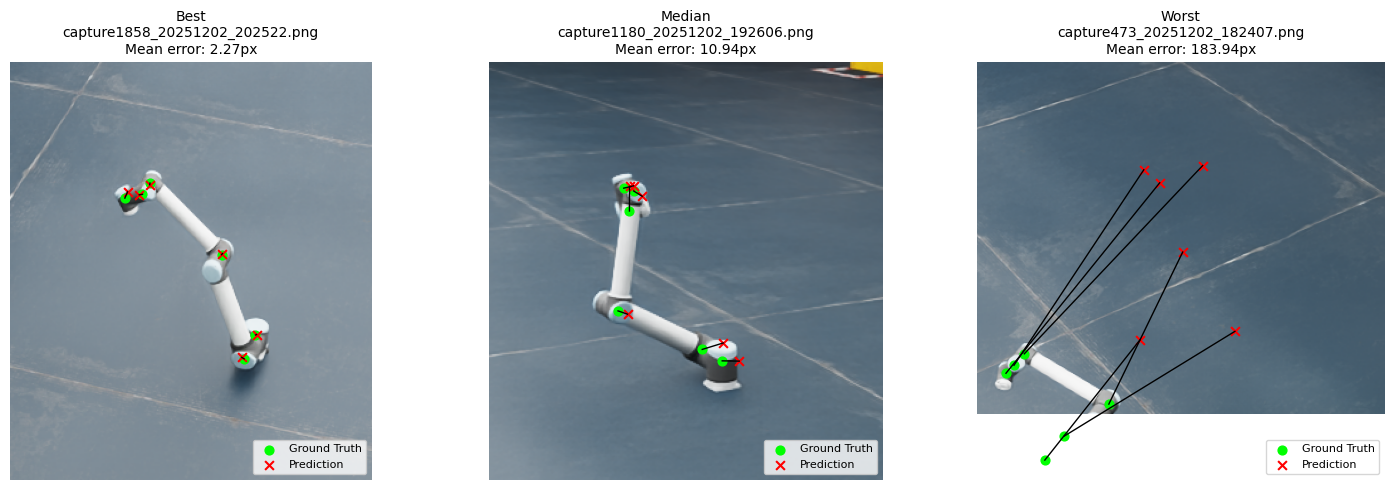

In [77]:
# PLOT BEST, MEDIAN AND WORST

joints = ["Base", "Shoulder", "Elbow", "Wrist3", "Wrist4", "Wrist5"]

def plot_cropped_best_worst(df, show_gt=True, show_pred=True):
    
    # Compute Average error
    error_cols = [f"error_2d_{j}_px" for j in joints]
    mean_error = df[error_cols].mean(axis=1)

    best_idx = mean_error.idxmin()
    worst_idx = mean_error.idxmax()
    median_val = mean_error.median()
    median_idx = (mean_error - median_val).abs().idxmin()

    ordered_indices = [best_idx, median_idx, worst_idx]
    labels = ["Best", "Median", "Worst"]

    plt.figure(figsize=(5 * 3, 5))

    for i, (idx, label) in enumerate(zip(ordered_indices, labels)):
        row = df.loc[idx]
        img = Image.open(row["img_path"])

        # Bounding Box
        xmin = int(row["pred_bbox_xmin"])
        ymin = int(row["pred_bbox_ymin"])
        xmax = int(row["pred_bbox_xmax"])
        ymax = int(row["pred_bbox_ymax"])

        # Crop Image 
        w, h = img.size
        xmin = max(0, min(xmin, w - 1))
        xmax = max(0, min(xmax, w))
        ymin = max(0, min(ymin, h - 1))
        ymax = max(0, min(ymax, h))
        cropped = img.crop((xmin, ymin, xmax, ymax))

        plt.subplot(1, 3, i + 1)
        plt.imshow(cropped)
        plt.axis("off")

        # Plot GT joints
        xs_gt, ys_gt = [], []
        if show_gt:
            for joint in joints:
                xg = row[f"gt_{joint}_x"] - xmin
                yg = row[f"gt_{joint}_y"] - ymin
                xs_gt.append(xg)
                ys_gt.append(yg)
            plt.scatter(xs_gt, ys_gt, c="lime", s=40, marker="o", label="Ground Truth")

        # Plot predicted joints
        xs_pred, ys_pred = [], []
        if show_pred:
            for joint in joints:
                xp = row[f"pred_{joint}_x"] - xmin
                yp = row[f"pred_{joint}_y"] - ymin
                xs_pred.append(xp)
                ys_pred.append(yp)
            plt.scatter(xs_pred, ys_pred, c="red", s=40, marker="x", label="Prediction")

        # Draw error lines between GT and Pred
        if show_gt and show_pred:
            for xg, yg, xp, yp in zip(xs_gt, ys_gt, xs_pred, ys_pred):
                plt.plot([xg, xp], [yg, yp], color="black", linewidth=1)

        # Title
        frame_mean_err = mean_error.loc[idx]
        fname = row["img_path"].split("/")[-1]
        plt.title(f"{label}\n{fname}\nMean error: {frame_mean_err:.2f}px", fontsize=10)

        plt.legend(loc="lower right", fontsize=8)

    plt.tight_layout()
    plt.show()

plot_cropped_best_worst(results_df)


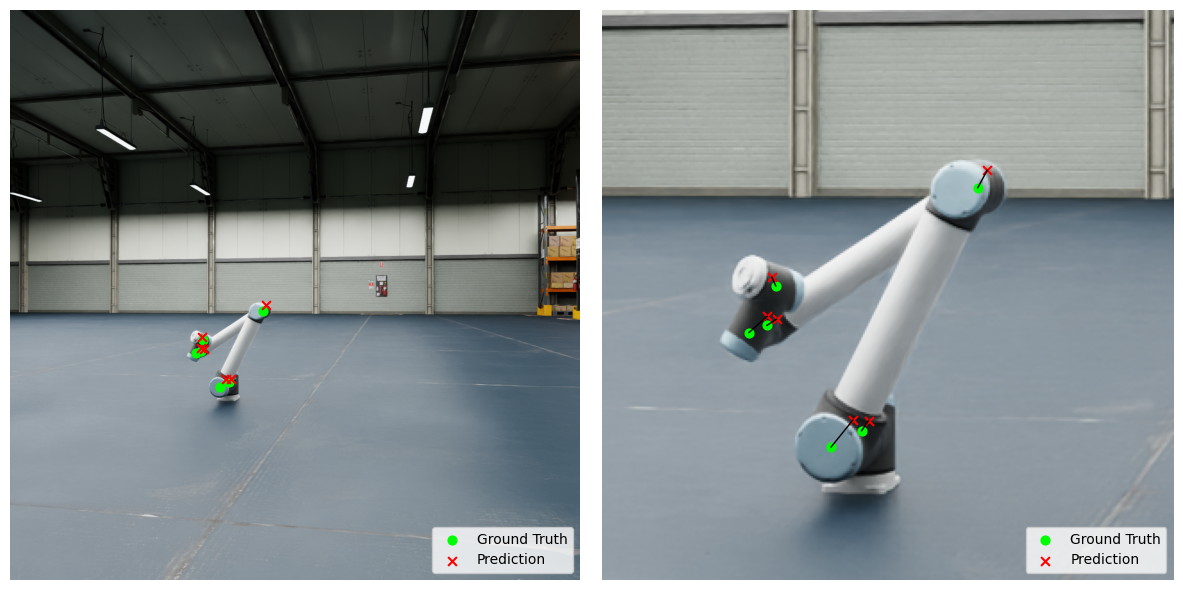

In [ ]:
# Plot Same Image Pre and Post Crop. Specify index
def plot_cropped_keyframe(df, row_idx, show_gt=True, show_pred=True):

    df['img_path'] = df['img_path'].str.replace('../../', '')
    row = df.loc[row_idx]
    img = Image.open(row["img_path"])
    w, h = img.size

    # Get predicted bounding box
    xmin = max(0, min(int(row["pred_bbox_xmin"]), w - 1))
    ymin = max(0, min(int(row["pred_bbox_ymin"]), h - 1))
    xmax = max(0, min(int(row["pred_bbox_xmax"]), w))
    ymax = max(0, min(int(row["pred_bbox_ymax"]), h))
    cropped = img.crop((xmin, ymin, xmax, ymax))


    plt.figure(figsize=(12, 6))

    # Original Plot
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")

    if show_gt:
        xs_gt = [row[f"gt_{j}_x"] for j in joints]
        ys_gt = [row[f"gt_{j}_y"] for j in joints]
        plt.scatter(xs_gt, ys_gt, c="lime", s=40, marker="o", label="Ground Truth")

    if show_pred:
        xs_pred = [row[f"pred_{j}_x"] for j in joints]
        ys_pred = [row[f"pred_{j}_y"] for j in joints]
        plt.scatter(xs_pred, ys_pred, c="red", s=40, marker="x", label="Prediction")

    plt.legend(loc="lower right")

    # Cropped Image
    plt.subplot(1, 2, 2)
    plt.imshow(cropped)
    plt.axis("off")

    if show_gt:
        xs_gt_crop = [row[f"gt_{j}_x"] - xmin for j in joints]
        ys_gt_crop = [row[f"gt_{j}_y"] - ymin for j in joints]
        plt.scatter(xs_gt_crop, ys_gt_crop, c="lime", s=40, marker="o", label="Ground Truth")

    if show_pred:
        xs_pred_crop = [row[f"pred_{j}_x"] - xmin for j in joints]
        ys_pred_crop = [row[f"pred_{j}_y"] - ymin for j in joints]
        plt.scatter(xs_pred_crop, ys_pred_crop, c="red", s=40, marker="x", label="Prediction")

    if show_gt and show_pred:
        for xg, yg, xp, yp in zip(xs_gt_crop, ys_gt_crop, xs_pred_crop, ys_pred_crop):
            plt.plot([xg, xp], [yg, yp], c="black", linewidth=1)

    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plot_cropped_keyframe(results_df, 54)


# Angluar Error Graphs



In [ ]:
# Load Dataset and Synce with image paths
path = "robot_pose_estimation/results/data/predictions.csv"

#Show Columns
results_df = pd.read_csv(path)
#list(results_df.columns)

In [ ]:
joints = ["Base", "Shoulder", "Elbow", "Wrist3", "Wrist4", "Wrist5"]
errors_deg = {}


for [joint, j] in zip(joints, range(4)):
    gt = results_df[f"gt_angle_J{j}_deg"]
    pred = results_df[f"est_angle_J{j}_deg"]
    error = pred - gt
    errors_deg[joint] = abs(error)

(1804, 4)


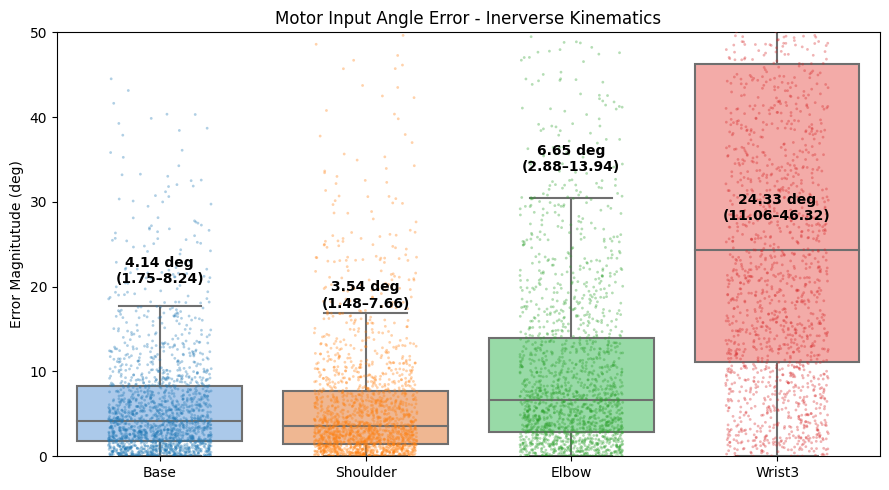

In [81]:
plt.figure(figsize=(9, 5))

error_df = pd.DataFrame(errors_deg)

error_df = error_df.replace([np.inf, -np.inf], np.nan)
error_df = error_df.dropna()

print(error_df.shape)

sns.boxplot(data=error_df,showfliers=False,palette = "pastel")
sns.stripplot(data=error_df,jitter=0.25,size=2,alpha=0.35)

# Plot median +/- IQR
# Plot median +/- IQR
medians = error_df.median()
q1, q3 = error_df.quantile(0.25), error_df.quantile(0.75)
x_positions = np.arange(len(error_df.columns))

for i, col in enumerate(error_df.columns):
    median = medians[col]
    q1_val, q3_val = q1[col], q3[col]
    
    if i == 3:
        plt.text(i, 27.5,
            f"{median:.2f} deg\n({q1_val:.2f}–{q3_val:.2f})",
            ha='center', va='bottom',fontsize=10, fontweight='bold')
    elif i==2:
        plt.text(i, median * 5,
            f"{median:.2f} deg\n({q1_val:.2f}–{q3_val:.2f})",
            ha='center', va='bottom',fontsize=10, fontweight='bold')
    else:
        plt.text(i, median * 4.85,
        f"{median:.2f} deg\n({q1_val:.2f}–{q3_val:.2f})",
        ha='center', va='bottom',fontsize=10, fontweight='bold')
    
    
    
# Clip outliers
upper = error_df.quantile(0.99)
lower = error_df.quantile(0.01)
clipped = clipped = error_df.clip(lower = lower, upper=upper, axis=1)
plt.ylim(0, 50)



plt.ylabel("Error Magnitutude (deg)")
plt.title("Motor Input Angle Error - Inerverse Kinematics")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

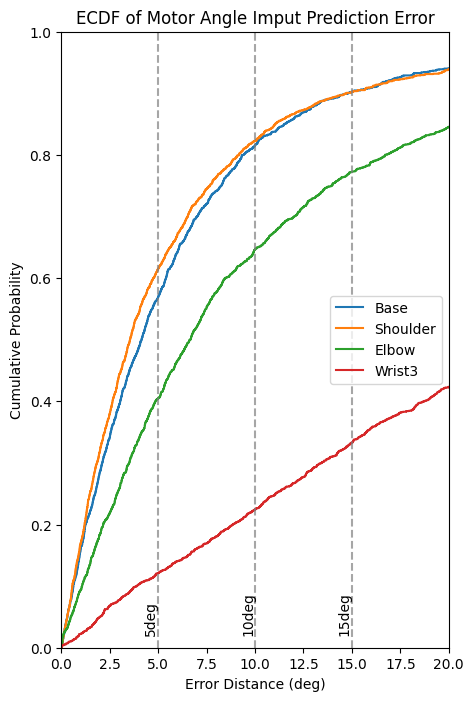

In [82]:
plt.figure(figsize=(5, 8))
for [joint, j] in zip(joints, range(4)):
    sns.ecdfplot(error_df[joint], label=joint)
    
thresholds = [5, 10, 15]
for t in thresholds:
    plt.axvline(t, linestyle="--", color="grey", alpha=0.7)
    plt.text(t, 0.02, f"{t}deg", rotation=90, va="bottom", ha="right")

plt.legend()
plt.xlim(0,20)
plt.xlabel("Error Distance (deg)")
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Motor Angle Imput Prediction Error")
plt.legend(loc="center right")

AUC (0–20 cm) per joint:
Base: 0.706
Shoulder: 0.719
Elbow: 0.570
Wrist3: 0.223


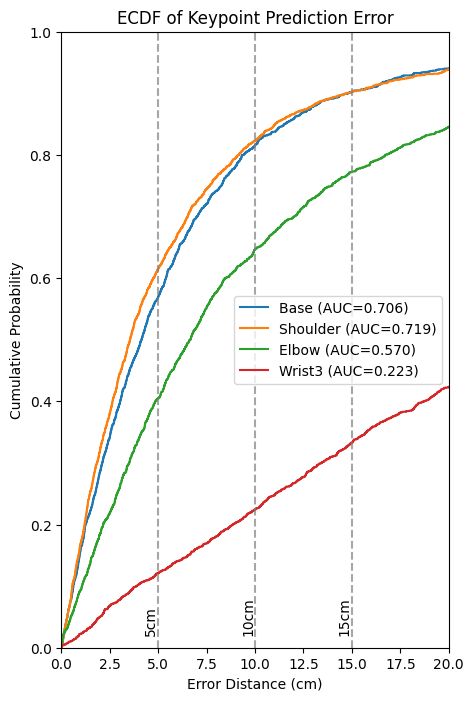

In [83]:
max_dist = 20  # cm, same as your x-limit
joints = ["Base", "Shoulder", "Elbow", "Wrist3", "Wrist4", "Wrist5"]


plt.figure(figsize=(5, 8))

aucs = {}

for [joint, j] in zip(joints, range(4)):

    errors = error_df[joint].dropna().values
    x = np.sort(errors)
    y = np.arange(1, len(x) + 1) / len(x)
    

    mask = x <= max_dist
    x_clip = x[mask]
    y_clip = y[mask]
    
    if len(x_clip) == 0:
        continue

    auc = np.trapz(y_clip, x_clip) / max_dist
    aucs[joint] = auc
    

    sns.ecdfplot(x, label=f"{joint} (AUC={auc:.3f})")

# Threshold lines
thresholds = [5, 10, 15]
for t in thresholds:
    plt.axvline(t, linestyle="--", color="grey", alpha=0.7)
    plt.text(t, 0.02, f"{t}cm", rotation=90, va="bottom", ha="right")

plt.legend()
plt.xlim(0, max_dist)
plt.xlabel("Error Distance (cm)")
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Keypoint Prediction Error")
plt.legend(loc="center right")


print(f"AUC (0–{max_dist} cm) per joint:")
for joint, auc in aucs.items():
    print(f"{joint}: {auc:.3f}")
